# Seafood Restaurants in Boston Neighborhoods

#### 1. Introduction/Business Problem

#### 2. Description of the Data

#### 3. Methodology

#### 4. Results 

#### 5. Conclusions

#### 6. Acknowledgement

## Introduction/Business Problem

The city of Boston is truly a multicultural and diverse city in the United States. It has a lot to offer: rich history, culture, sports, higher education, healthcare, and of course the fresh sea foods. Millions of visitors from all over the world visit Boston every year and many of them crave for Boston’s famous seafood. Locally harvested lobsters, oysters, cod, tuna, and many other species provide a plethora of options to choose from. 

In this project I want to provide a simple recommendation system to the visitors to choose a Boston neighborhood with the highest concentration of Seafood restaurants so that they will have many options to choose from. It will provide visual locations of the restaurants in the map which can be zoomed in or out to help planning a better visit. 


Import the necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests

from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

#### 2. Description of the Data

For this project, I will scrap the Boston neighborhoods data from Wikipedia (Neighborhoods in Boston - Wikipedia) using the Beautiful Soup library and I will obtain the restaurant information in Boston neighborhoods from Foursquare using an API. These two sets of data will be merged, a cluster analysis will be performed by the k nearest neighbors regression method followed by the creation of a geographical map using folium library.


The get request and beautiful soup object was created to fetch the neighborhood data from wikipedia.

In [2]:
# create the GET request
boston_neighborhoods_data = requests.get("https://en.wikipedia.org/wiki/Neighborhoods_in_Boston").text

In [3]:
# parse data from the html into a beautifulsoup object
Bsoup_obj = BeautifulSoup(boston_neighborhoods_data, 'html.parser')

The neighborhood data was stored in "boston_neighborhoods" list.

In [4]:
# create an empty list to store neighborhood data
boston_neighborhoods = []

In [5]:
# append the data into the list
for row in Bsoup_obj.find_all("div", class_="div-col")[0].findAll("li"):
    boston_neighborhoods.append(row.text)
boston_neighborhoods

['Allston',
 'Back Bay',
 'Bay Village',
 'Beacon Hill',
 'Brighton',
 'Charlestown',
 'Chinatown–Leather District',
 'Dorchester (divided for planning purposes into Mid-Dorchester and Dorchester)',
 'Downtown',
 'East Boston',
 'Fenway-Kenmore (includes Longwood)',
 'Hyde Park',
 'Jamaica Plain',
 'Mattapan',
 'Mission Hill',
 'North End',
 'Roslindale',
 'Roxbury',
 'South Boston',
 'South End',
 'West End',
 'West Roxbury',
 'Wharf District']

#### 3. Methodology

A pandas data frame was created from the "boston_neighborhoods" list.

In [6]:
# create a new DataFrame from the list
b_neigh_df = pd.DataFrame({"Neighborhood": boston_neighborhoods})
b_neigh_df.head(6)

,Neighborhood
0,Allston
1,Back Bay
2,Bay Village
3,Beacon Hill
4,Brighton
5,Charlestown


In [7]:
# print the number of rows of the dataframe
b_neigh_df.shape

(23, 1)

A function was created and called upon the neighborhoods to get their latitude and longitude coordinates.

In [8]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Boston, Massachusetts'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [9]:
# call the function to get the coordinates, store in a new list using list comprehension
bos_neigh_coords = [ get_latlng(neighborhood) for neighborhood in b_neigh_df["Neighborhood"].tolist() ]
bos_neigh_coords

[[42.354332000000056, -71.14091799999994],
 [42.34999000000005, -71.08764999999994],
 [42.34816503121898, -71.06846991510525],
 [42.35842000000008, -71.06859999999995],
 [42.35213365368456, -71.12492527560583],
 [42.3677501180056, -71.05905551335397],
 [42.35251000000005, -71.06089999999995],
 [42.32989003058984, -71.05694991119995],
 [42.35829000000007, -71.05662999999998],
 [42.35141817326235, -71.05671435784329],
 [42.34355000000005, -71.10156999999998],
 [42.27477303496225, -71.11989847471231],
 [42.30584890846422, -71.11909201668144],
 [42.278222288859574, -71.0960831569464],
 [42.33571000000006, -71.10979999999995],
 [42.36549000000008, -71.05296999999996],
 [42.28182009628248, -71.13710364030405],
 [42.330303515648225, -71.08946869163574],
 [42.3522498538783, -71.05568998397878],
 [42.34256000000005, -71.07357999999994],
 [42.36394000000007, -71.06738999999999],
 [42.28220076055744, -71.14599982157858],
 [42.32522395859234, -71.06224830446084]]

The coordinates were converted into a pandas data frame from the list.

In [10]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
bos_neigh_coords = pd.DataFrame(bos_neigh_coords, columns=['Latitude', 'Longitude'])

In [11]:
# merge the coordinates into the original dataframe
b_neigh_df['Latitude'] = bos_neigh_coords['Latitude']
b_neigh_df['Longitude'] = bos_neigh_coords['Longitude']

In [12]:
# check the neighborhoods and the coordinates
b_neigh_df.head()

,Neighborhood,Latitude,Longitude
0,Allston,42.354332,-71.140918
1,Back Bay,42.349990,-71.087650
2,Bay Village,42.348165,-71.068470
3,Beacon Hill,42.358420,-71.068600
4,Brighton,42.352134,-71.124925


Coordinates of Boston were retrieved using geocoder library and a map of Boston along with the neighborhoods will be created using folium library.

In [13]:
# get the coordinates of Boston, Massachusetts
city = 'Boston, Massachusetts'

geolocator = Nominatim(user_agent="sk")
location = geolocator.geocode(city)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Boston, Massachusetts {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Boston, Massachusetts 42.3602534, -71.0582912.


In [14]:
# create a map of Boston using latitude and longitude values
boston_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add neighborhood markerss to map
for lat, lng, neighborhood in zip(b_neigh_df['Latitude'], b_neigh_df['Longitude'], b_neigh_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(boston_map)  
    
boston_map

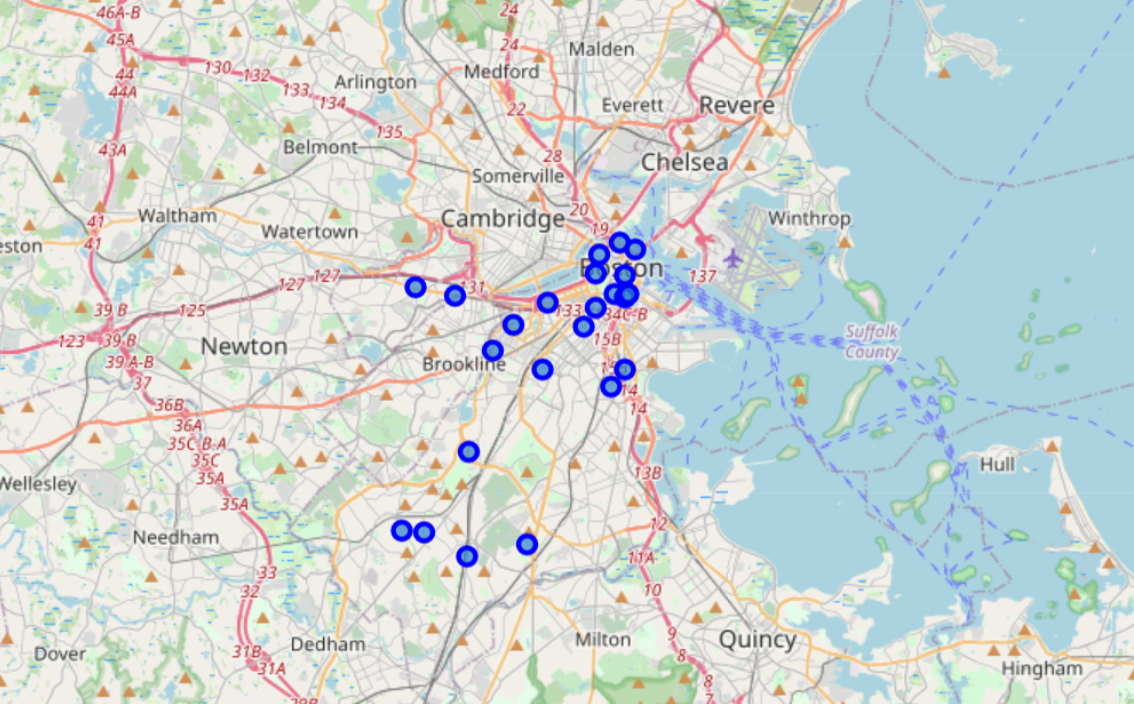

Boston neighborhoods venues were explored using foursquare API.

In [15]:
CLIENT_ID = 'TVLBCGAELCWQFC1M4DQG4V5DWZDPGZZCJMO2KN3D5EDE1AVT' 
CLIENT_SECRET = '5N5ZIQYECVTYBHLS4MRF2UZHVYOBOSQV2S1I45CMJSZ330RW' 
VERSION = '20180605' 
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TVLBCGAELCWQFC1M4DQG4V5DWZDPGZZCJMO2KN3D5EDE1AVT
CLIENT_SECRET:5N5ZIQYECVTYBHLS4MRF2UZHVYOBOSQV2S1I45CMJSZ330RW


In [16]:
radius = 3000
LIMIT = 500

boston_venues = []
for lat, long, neighborhood in zip(b_neigh_df['Latitude'], b_neigh_df['Longitude'], b_neigh_df['Neighborhood']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        boston_venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [17]:
# convert the venues list into a new DataFrame
boston_venues_df = pd.DataFrame(boston_venues)

# define the column names
boston_venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

boston_venues_df.head(6)

,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Allston,42.354332,-71.140918,Whole Heart Provisions,42.353745,-71.137189,Vegetarian / Vegan Restaurant
1,Allston,42.354332,-71.140918,Kohi Coffee,42.356692,-71.142516,Café
2,Allston,42.354332,-71.140918,NB Fitness Club,42.357121,-71.146161,Gym
3,Allston,42.354332,-71.140918,Lulu's Allston,42.355068,-71.134107,Comfort Food Restaurant
4,Allston,42.354332,-71.140918,Fish Market Sushi Bar,42.353039,-71.132975,Sushi Restaurant
5,Allston,42.354332,-71.140918,Mala Restaurant,42.352960,-71.131033,Chinese Restaurant


In [18]:
boston_venues_df.groupby(["Neighborhood"]).count()

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
Allston,100,100,100,100,100,100
Back Bay,100,100,100,100,100,100
Bay Village,100,100,100,100,100,100
Beacon Hill,100,100,100,100,100,100
Brighton,100,100,100,100,100,100
Charlestown,100,100,100,100,100,100
Chinatown–Leather District,100,100,100,100,100,100
Dorchester (divided for planning purposes into Mid-Dorchester and Dorchester),100,100,100,100,100,100
Downtown,100,100,100,100,100,100


In [19]:
print('There are {} uniques venue categories in Boston Neighborhoods.'.format(len(boston_venues_df['VenueCategory'].unique())))

There are 168 uniques venue categories in Boston Neighborhoods.


In [20]:
boston_venues_df.shape

(2292, 7)

A list of top 20 venue categories in Boston Neighborhoods was created.

In [21]:
boston_venues_df['VenueCategory'].unique()[:20]

array(['Vegetarian / Vegan Restaurant', 'Café', 'Gym',
       'Comfort Food Restaurant', 'Sushi Restaurant',
       'Chinese Restaurant', 'Bakery', 'Fried Chicken Joint',
       'Japanese Restaurant', 'Pizza Place', 'Taco Place',
       'Italian Restaurant', 'Bar', 'Diner', 'Deli / Bodega',
       'Greek Restaurant', 'Pub', 'Spa', 'Garden Center',
       'Dumpling Restaurant'], dtype=object)

In [22]:
# create a dataframe of top 20 categories
top20_boston_Venues = boston_venues_df['VenueCategory'].value_counts()[0:20].to_frame(name='frequency')
top20_boston_Venues =top20_boston_Venues.reset_index()
top20_boston_Venues.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
top20_boston_Venues

,Venue_Category,Frequency
0,Pizza Place,113
1,Italian Restaurant,109
2,Bakery,102
3,Park,92
4,Coffee Shop,75
5,Sandwich Place,71
6,Seafood Restaurant,64
7,American Restaurant,51
8,Hotel,48
9,Grocery Store,45


A histogram was plotted for the top twenty venues in Boston neighborhoods.

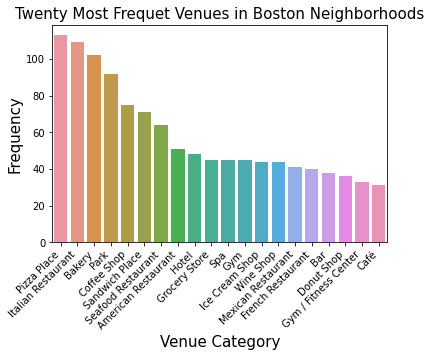

<Figure size 1440x648 with 0 Axes>

In [23]:
s=sns.barplot(x="Venue_Category", y="Frequency", data=top20_boston_Venues)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('Twenty Most Frequet Venues in Boston Neighborhoods', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
#plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(20,9))
plt.show()

In [24]:
# one hot encoding
boston_onehot = pd.get_dummies(boston_venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
boston_onehot['Neighborhoods'] = boston_venues_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [boston_onehot.columns[-1]] + list(boston_onehot.columns[:-1])
boston_onehot = boston_onehot[fixed_columns]

print(boston_onehot.shape)
boston_onehot.head(6)

(2292, 169)


,Neighborhoods,Accessories Store,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Beach,Beer Bar,Beer Garden,Belgian Restaurant,Big Box Store,Boat or Ferry,Bookstore,Boxing Gym,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Café,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Donut Shop,Dumpling Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Historic Site,History Museum,Hockey Arena,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Library,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Noodle House,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Plaza,Post Office,Pub,Record Shop,Rental Car Location,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shopping Mall,Snack Place,Social Club,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,Allston,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,Allston,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Allston,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Allston,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Allston,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [25]:
boston_grouped = boston_onehot.groupby(["Neighborhoods"]).mean().reset_index()
boston_grouped

,Neighborhoods,Accessories Store,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Beach,Beer Bar,Beer Garden,Belgian Restaurant,Big Box Store,Boat or Ferry,Bookstore,Boxing Gym,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Café,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Donut Shop,Dumpling Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Historic Site,History Museum,Hockey Arena,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Library,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Noodle House,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Plaza,Post Office,Pub,Record Shop,Rental Car Location,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shopping Mall,Snack Place,Social Club,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,Allston,0.00,0.010000,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00000,0.00,0.01000,0.070000,0.00,0.040000,0.00,0.00,0.00,0.00,0.00,0.00000,0.00,0.01,0.00,0.01000,0.00,0.01,0.01,0.03,0.000000,0.01,0.00,0.00,0.01,0.00,0.03000,0.00,0.01,0.00,0.000000,0.00,0.01,0.00,0.00,0.00,0.00,0.02,0.00,0.01,0.000000,0.00,0.00,0.00,0.010000,0.01,0.00,0.00,0.01,0.00,0.00000,0.000000,0.00,0.00,0.01,0.01,0.00,0.02000,0.00,0.00,0.01,0.00000,0.01,0.01,0.00000,0.01,0.02,0.04000,0.030000,0.03,0.01,0.00,0.00,0.00,0.000000,0.00,0.000000,0.01,0.00,0.01,0.020000,0.020000,0.01,0.00,0.010000,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00000,0.01,0.00,0.020000,0.00,0.00,0.000000,0.00,0.070000,0.00000,0.00,0.02000,0.00,0.000000,0.01000,0.00,0.00,0.00,0.020000,0.01000,0.00,0.02,0.00,0.00000,0.00,0.00,0.01000,0.01000,0.00,0.01,0.00,0.00000,0.00,0.02,0.01,0.02,0.01,0.00,0.00,0.00,0.00,0.01,0.02,0.00,0.000000,0.00000,0.00,0.00,0.00,0.01000,0.00,0.00
1,Back Bay,0.00,0.040000,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00000,0.01,0.00000,0.030000,0.00,0.020000,0.01,0.00,0.00,0.00,0.00,0.00000,0.00,0.01,0.00,0.01000,0.00,0.01,0.00,0.01,0.000000,0.00,0.01,0.00,0.02,0.00,0.05000,0.00,0.01,0.01,0.000000,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.000000,0.01,0.00,0.01,0.010000,0.00,0.00,0.00,0.00,0.00,0.01000,0.000000,0.00,0.00,0.00,0.00,0.02,0.00000,0.00,0.01,0.01,0.00000,0.01,0.01,0.00000,0.01,0.01,0.01000,0.020000,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.05,0.00,0.00,0.020000,0.000000,0.00,0.00,0.050000,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.02,0.00,0.01,0.01,0.010000,0.00,0.01,0

In [26]:
len(boston_grouped[boston_grouped["Seafood Restaurant"] > 0])

19

A separated dataframe was created only for the seafood restaurants along with their geographical coordinates.

In [27]:
boston_sf = boston_grouped[["Neighborhoods","Seafood Restaurant"]]
boston_sf.head()

,Neighborhoods,Seafood Restaurant
0,Allston,0.02
1,Back Bay,0.04
2,Bay Village,0.03
3,Beacon Hill,0.04
4,Brighton,0.02


In [28]:
b_sf_clustering = boston_sf.drop(["Neighborhoods"], 1)

#### K-Nearest Neighbors
For this project, K-Nearest Neighbors is the preferable algorithm for classification. K-Nearest Neighbors is an algorithm for unsupervised learning. Where the data is 'trained' with data points corresponding to their classification. Once a point is to be predicted, it takes into account the 'K' nearest points to it to determine its classification.

#### Elbow method to determine the optimum number of clusters

It's not always obvious from the scatter plot of the data what should be the optimum number of clusters. The most popular method for determining the optimum number of clusters for k nearest neighbour unsupervised algorithm is the elbow method; where the distortion is plotted against the number of clusters and the elbow in the plot represents the optimum number of clusters.

<ipython-input-29-a909fbfc379f>:8: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  km.fit(b_sf_clustering)
<ipython-input-29-a909fbfc379f>:8: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  km.fit(b_sf_clustering)
<ipython-input-29-a909fbfc379f>:8: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  km.fit(b_sf_clustering)


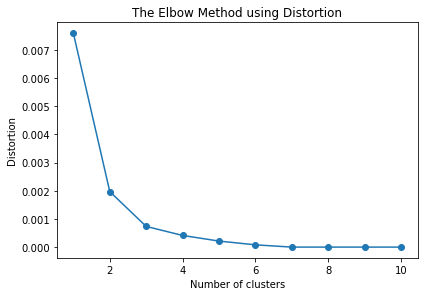

In [29]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(b_sf_clustering)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.title('The Elbow Method using Distortion')
plt.show()

From the plot of distortion vs number of clusters, it is clear that three clusters will be optimum for k nearest neighbor modelling on this data set.

In [30]:
# set number of clusters
k_clusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(b_sf_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 1, 2, 1, 2, 2, 1, 2, 1, 1])

Let's create a new dataframe that includes the cluster as well as the top 20 venues for each neighborhood.

In [31]:
b_sf_merged = boston_sf.copy()

# add clustering labels
b_sf_merged["Cluster Labels"] = kmeans.labels_

In [32]:
b_sf_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
b_sf_merged.head()

,Neighborhood,Seafood Restaurant,Cluster Labels
0,Allston,0.02,2
1,Back Bay,0.04,1
2,Bay Village,0.03,2
3,Beacon Hill,0.04,1
4,Brighton,0.02,2


boston_seafood_grouped is merged with boston_data to add latitude/longitude for each neighborhood.

In [33]:
b_sf_merged = b_sf_merged.join(b_neigh_df.set_index("Neighborhood"), on="Neighborhood")

print(b_sf_merged.shape)

(23, 5)


Let's sort the results by Cluster Labels.

In [34]:
b_sf_merged.sort_values(["Cluster Labels"], inplace=True)
b_sf_merged

,Neighborhood,Seafood Restaurant,Cluster Labels,Latitude,Longitude
11,Hyde Park,0.00,0,42.274773,-71.119898
16,Roslindale,0.00,0,42.281820,-71.137104
21,West Roxbury,0.00,0,42.282201,-71.146000
12,Jamaica Plain,0.01,0,42.305849,-71.119092
13,Mattapan,0.00,0,42.278222,-71.096083
14,Mission Hill,0.01,0,42.335710,-71.109800
1,Back Bay,0.04,1,42.349990,-71.087650
20,West End,0.05,1,42.363940,-71.067390
3,Beacon Hill,0.04,1,42.358420,-71.068600
19,South End,0.04,1,42.342560,-71.073580


Finally, let's map the three clusters in Boston neighborhood using folium library.

In [35]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(b_sf_merged['Latitude'], b_sf_merged['Longitude'], b_sf_merged['Neighborhood'], b_sf_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

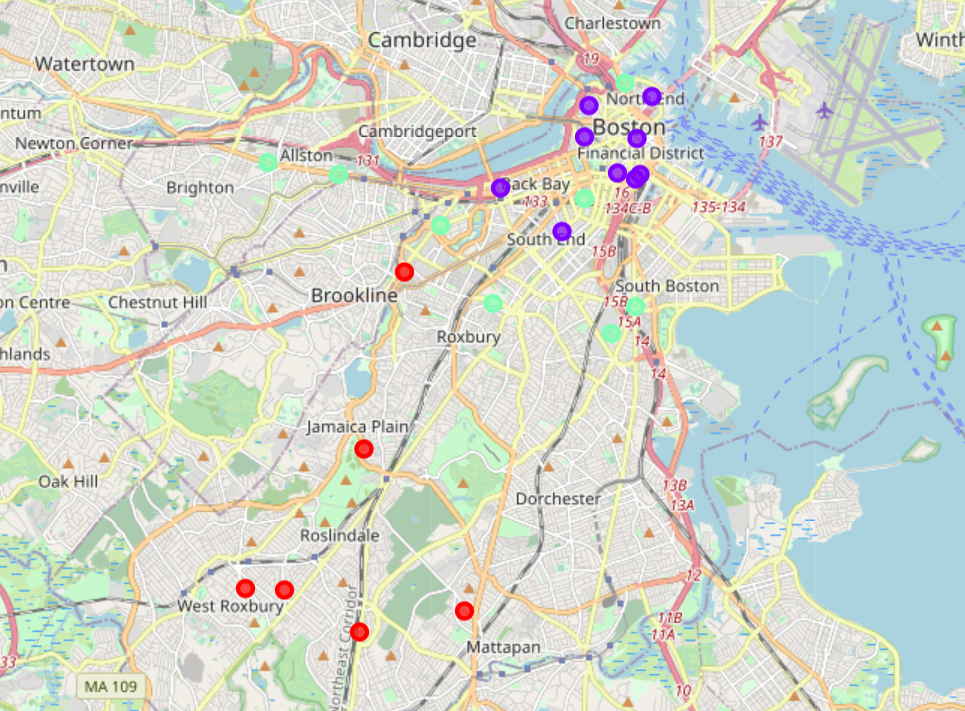

#### Cluster 1 (Red Circles)

In [36]:
b_sf_merged.loc[b_sf_merged['Cluster Labels'] == 0]

,Neighborhood,Seafood Restaurant,Cluster Labels,Latitude,Longitude
11,Hyde Park,0.00,0,42.274773,-71.119898
16,Roslindale,0.00,0,42.281820,-71.137104
21,West Roxbury,0.00,0,42.282201,-71.146000
12,Jamaica Plain,0.01,0,42.305849,-71.119092
13,Mattapan,0.00,0,42.278222,-71.096083
14,Mission Hill,0.01,0,42.335710,-71.109800


#### Cluster 2 (Purple Circles)

In [37]:
b_sf_merged.loc[b_sf_merged['Cluster Labels'] == 1]

,Neighborhood,Seafood Restaurant,Cluster Labels,Latitude,Longitude
1,Back Bay,0.04,1,42.349990,-71.087650
20,West End,0.05,1,42.363940,-71.067390
3,Beacon Hill,0.04,1,42.358420,-71.068600
19,South End,0.04,1,42.342560,-71.073580
18,South Boston,0.05,1,42.352250,-71.055690
6,Chinatown–Leather District,0.06,1,42.352510,-71.060900
8,Downtown,0.05,1,42.358290,-71.056630
9,East Boston,0.05,1,42.351418,-71.056714
15,North End,0.04,1,42.365490,-71.052970


#### Cluster 3 (Green Circles)

In [38]:
b_sf_merged.loc[b_sf_merged['Cluster Labels'] == 2]

,Neighborhood,Seafood Restaurant,Cluster Labels,Latitude,Longitude
17,Roxbury,0.03,2,42.330304,-71.089469
0,Allston,0.02,2,42.354332,-71.140918
7,Dorchester (divided for planning purposes into...,0.02,2,42.329890,-71.056950
5,Charlestown,0.03,2,42.367750,-71.059056
4,Brighton,0.02,2,42.352134,-71.124925
2,Bay Village,0.03,2,42.348165,-71.068470
10,Fenway-Kenmore (includes Longwood),0.03,2,42.343550,-71.101570
22,Wharf District,0.02,2,42.325224,-71.062248


#### 4. Results

Cluster 2, represented by purple circles in the map, has the highest concentration of seafood restaurants in Boston. Cluster 3, represented by green circles in the map has the second highest concentration, and Cluster 1, represented by red circles in the map has the lowest concentration of seafood restaurants in Boston.

#### 5. Conclusions

Downtown Boston and the nearby areas have the highest concentration of seafood restaurants, marked by purple circles in the map. As a whole, the city of Boston and the surrounding neighborhoods have many indoor and outdoor activities and plenty of food choices; both American and international.This project provides a visual map with the highest concentration of seafood restaurants to help visitors who want to enjoy Boston's famous seafood.

#### 6. Acknowledgement

This project is part of the IBM Data Science Capstone project in Coursera. Some codes for this project are reproduced from previous course materials. geeksforgeeks website (https://www.geeksforgeeks.org/) provided valuable resources for programming related concepts and clarifications.     